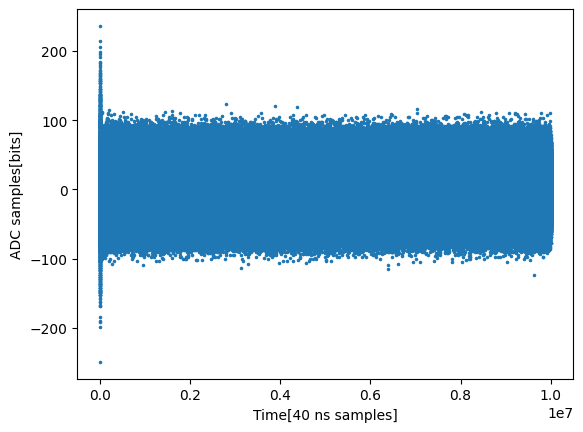

2.6404417
3.0
24.274426002047935


np.float64(2.4184373614843936e-15)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

data = np.fromfile("C:\\Users\\jasbi\\Downloads\\nov_20_10M_rmtmp_22.6_5.dat", dtype='int16')-2**11
data = data-np.mean(data) #removing the mean
plt.plot(data, ls='', marker='.', ms=3.1)
plt.ylabel("ADC samples[bits]")
plt.xlabel("Time[40 ns samples]")
plt.show()

print(np.mean(data))
print(np.median(data))
print(np.std(data))


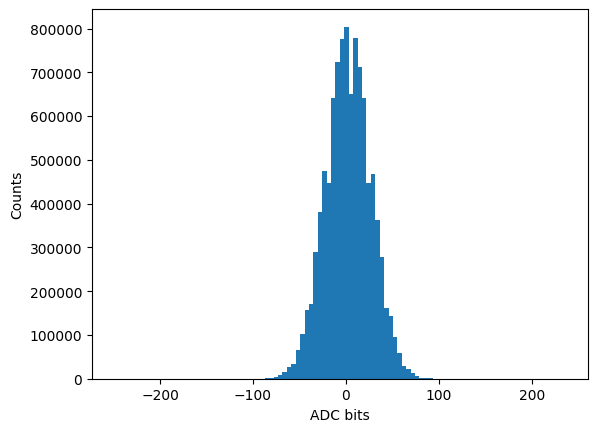

In [3]:
plt.hist(data, bins=102)
plt.ylabel("Counts")
plt.xlabel("ADC bits") #WTF is this axis #AAAAJFXJHGMV #LOSING MY MIND - fixed
plt.show()

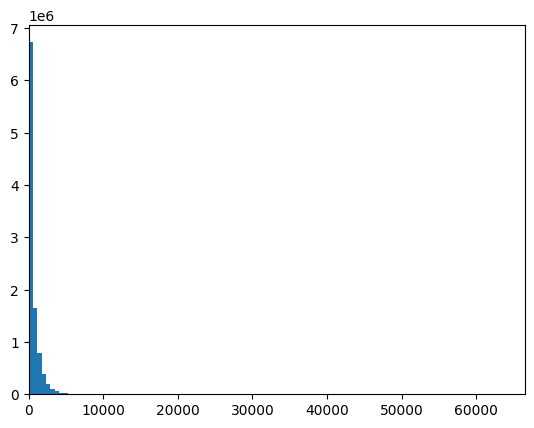

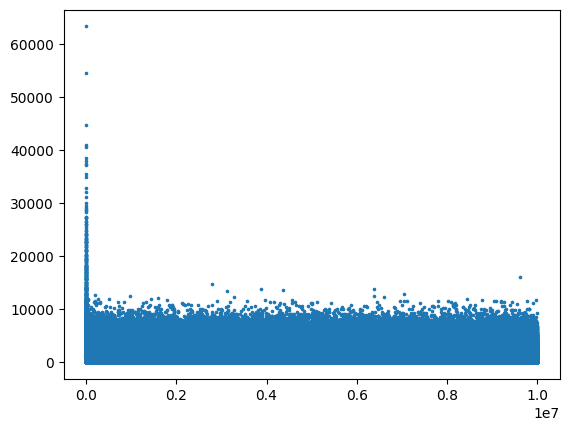

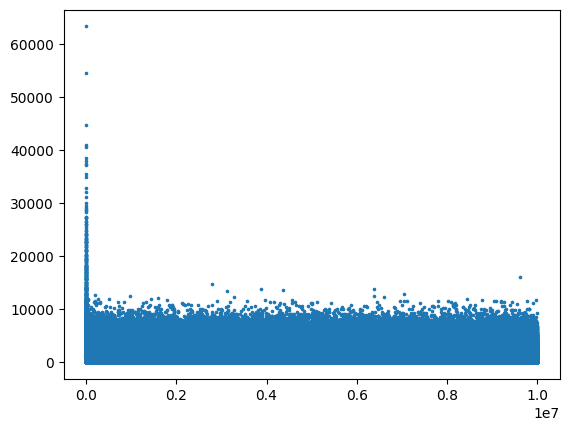

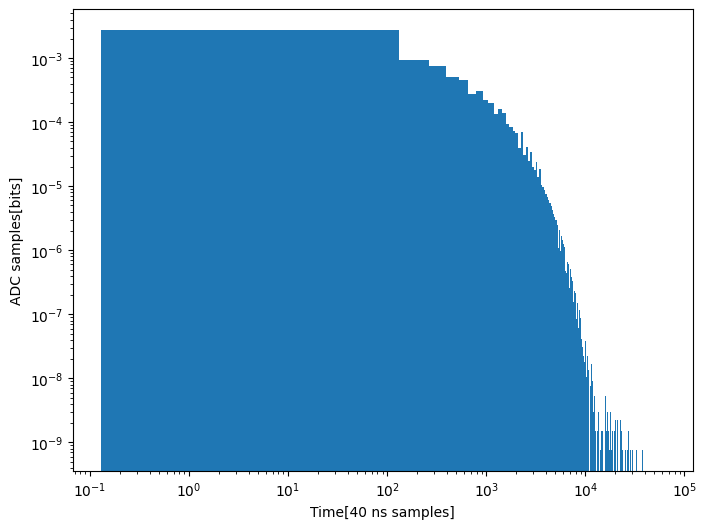

In [13]:
power = data**2
plt.hist(power, bins=108)
plt.xlim(0)
plt.show()

plt.plot(power,marker='.', ms=3.2, ls='')
plt.show()

#negative values arise because dtype is int16, it wraps around after 2^15 -1 
#so we shall fiter it out ^-^.
power_filtered = power[power >= 0.0] 
plt.plot(power_filtered, marker='.', ms=3.2, ls='')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(power_filtered, bins=480, density='True')
plt.xscale('log')
plt.yscale('log')
plt.ylabel("ADC samples[bits]")
plt.xlabel("Time[40 ns samples]")
plt.show()

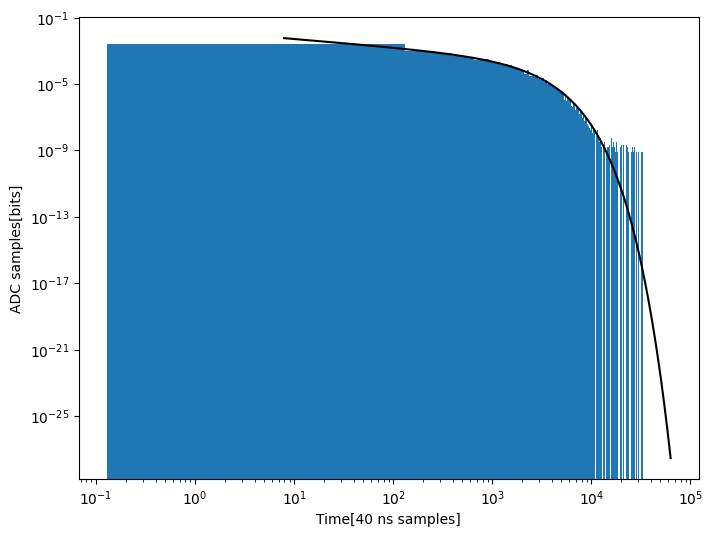

In [89]:
from scipy.stats import chi2

x = np.linspace(0, np.max(power_filtered), 8000)
df = 1
scale = np.mean(power_filtered)

#we shall return to this
#to be scaled/not to be scaled
#that is the question
plt.figure(figsize=(8, 6))
plt.hist(power_filtered, bins=480, density=True)
plt.plot(x, chi2.pdf(x, df, scale = scale), label='$chi_1^2$ PDF', color='black')
plt.yscale('log')
plt.xscale('log')
plt.ylabel("ADC samples[bits]")
plt.xlabel("Time[40 ns samples]")
plt.show()

Text(0.5, 0, 'Time[40 ns samples]')

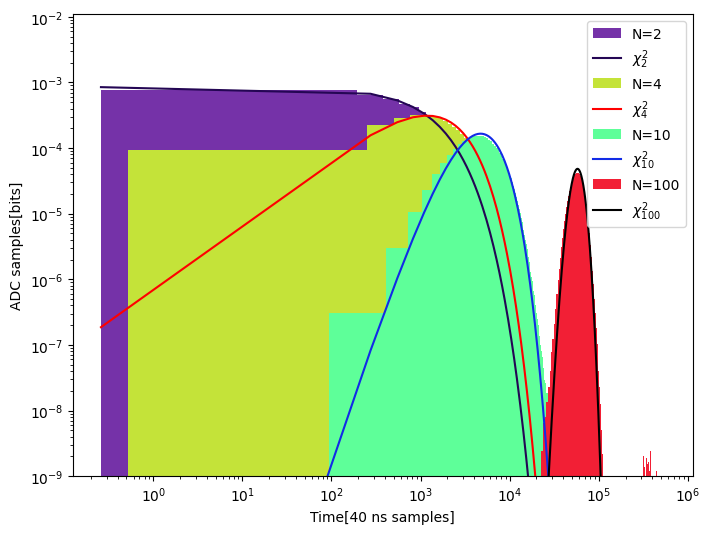

In [60]:

#we shall return to this
#to be scaled/not to be scaled
#that is the question

#SARGUN.EXE HAS STOPPED WORKING
#I SHALL RETURN TO THIS
N = [2, 4, 10, 100]
colors = ['#7532a8', '#c4e339', '#5eff99', '#f21f35' ]
color_lines = ['#240654', 'red', '#122be6', 'black']
hists = []
for n in N:
    windows = np.ones(n)
    hist_ = np.convolve(power_filtered, windows, mode='valid')
    hists.append(hist_)

i = 0
plt.figure(figsize=(8, 6))
xmin = min([h.min() for h in hists])
xmax = max([h.max() for h in hists])
x = np.linspace(xmin, xmax, 2000)

while i < len(hists):
    plt.hist(hists[i], bins=480, density=True, label='N='+ str(N[i]), color=colors[i])
    y = chi2.pdf(x, df=N[i], scale = np.mean(hists[i])/N[i])
    plt.plot(x, y, color=color_lines[i], label=fr'$\chi^2_{{{N[i]}}}$')
    i += 1

plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper right')
plt.ylim(10e-10, 10e-3+0.001)
plt.ylabel("ADC samples[bits]")
plt.xlabel("Time[40 ns samples]")

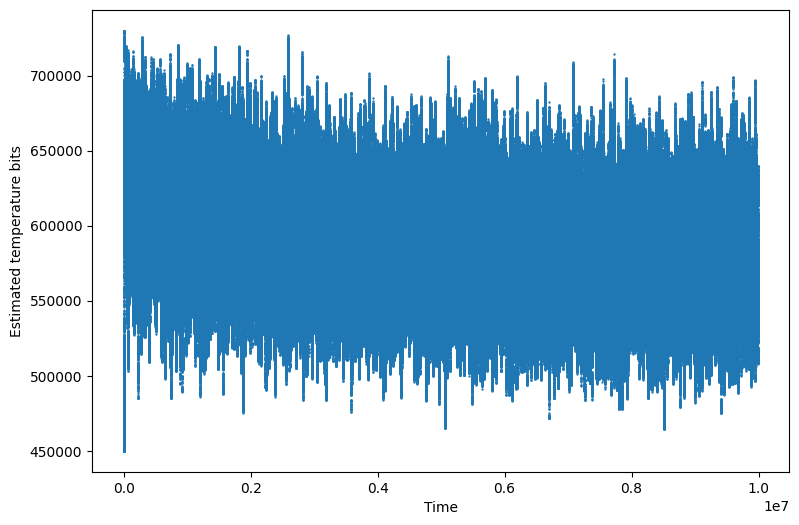

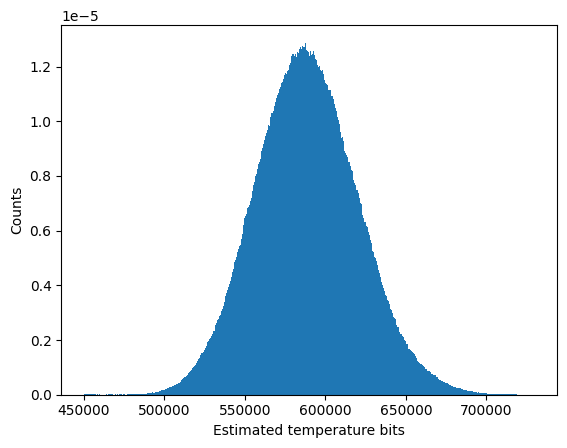

588487.2166762244
31859.272456454077
Time in each sample: 0.0002
Bandwidth: 2500.0
Ratio should be: 0.044721359549995794
observed ratio: 0.054137577764892225


In [74]:
#time to generate the temperature timestream
#CRACKS KNUCKLES
#IM READY
#to die
#T \propto P 
#THATS IT F THIS
n = 1000
windows = np.ones(n)
power_temp = np.convolve(power_filtered, windows, mode='valid')
power_temp = power_temp[power_temp <= 0.73e6]
power_temp = power_temp[power_temp >= 45e4]

plt.figure(figsize=(9, 6))
plt.plot(power_temp, ls='', marker='.', ms=1.4)
plt.xlabel('Time')
plt.ylabel('Estimated temperature bits')
plt.show()

plt.hist(power_temp, bins= 500, density=True)
plt.ylabel('Counts')
plt.xlabel('Estimated temperature bits')
plt.show()

print(np.mean(power_temp))
print(np.std(power_temp))
t = n/5e06 #THIS IS \TAU
print('Time in each sample: ' + str(t))

#bandwidth via Nyquist
#\Delta \mu = 1/ 2\tau
#total time t = N\tau
v = 1/ (2*t)
print('Bandwidth: ' + str(v))
print('Ratio should be: ' + str(1/np.sqrt(n*t*v)))
print('observed ratio: '+ str(np.std(power_temp)/np.mean(power_temp)))

In [77]:
power_ = power_temp[:2056]
out = np.fft.fft(power_)
out

array([1.03051295e+09-1.04191713e-08j, 6.32824144e+07-3.79049571e+07j,
       4.43165400e+07-5.41745885e+07j, ...,
       4.30593900e+06+5.82902421e+07j, 4.43165400e+07+5.41745885e+07j,
       6.32824144e+07+3.79049571e+07j])

In [109]:
def compute_spectrum(E, fs, LO, n_fft):
    n_blocks = len(E) // n_fft
    E = E[:n_blocks * n_fft]
    blocks = E.reshape(n_blocks, n_fft)
    X = np.fft.fft(blocks, axis=1)
    X = X[:, :n_fft//2]
    P = (np.abs(X)**2) / n_fft**2     # shape: (n_blocks, n_fft/2)
    Pavg = P.mean(axis=0)
    df = fs / n_fft
    freqs = LO + np.arange(n_fft//2) * df

    return freqs, Pavg, n_blocks

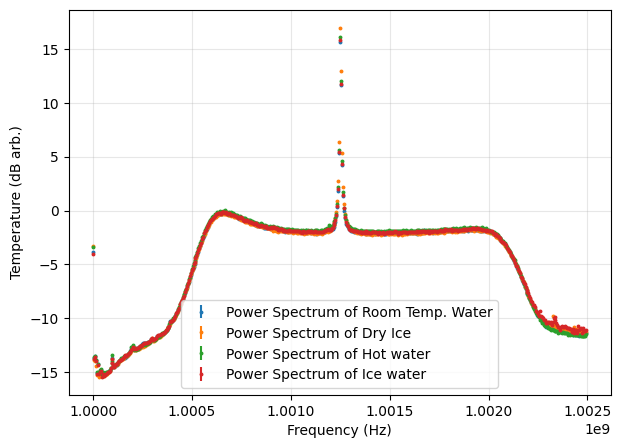

In [108]:
fs = 5e6  
LO = 1e9         
n_fft = 1024

data_room_temp = np.fromfile("C:\\Users\\jasbi\\Downloads\\nov_20_10M_rmtmp_22.6_5.dat", dtype='int16')-2**11
data_room_temp = data_room_temp-np.mean(data_room_temp)
data_dry_ice = np.fromfile("C:\\Users\\jasbi\\Downloads\\nov_20_10M_dryice_neg78.5_8.dat", dtype='int16')-2**11
data_dry_ice = data_dry_ice-np.mean(data_dry_ice)
data_hot_water = np.fromfile("C:\\Users\\jasbi\\Downloads\\nov_20_10M_83.3_6.dat", dtype='int16')-2**11
data_hot_water = data_hot_water-np.mean(data_hot_water)
data_cold_water = np.fromfile("C:\\Users\\jasbi\\Downloads\\nov_20_10M_icewat_4.9_5.dat", dtype='int16')-2**11
data_cold_water = data_cold_water-np.mean(data_cold_water)

datasets = [data_room_temp, data_dry_ice, data_hot_water, data_cold_water]
names = ['Room Temp. Water', 'Dry Ice', 'Hot water', 'Ice water']

plt.figure(figsize=(7,5))
i = 0
while i < len(datasets):
    freqs, Pavg, n_blocks = compute_spectrum(datasets[i], fs, LO, n_fft)
    
    # Convert to dB
    P_db = 10 * np.log10(Pavg)
    
    # Radiometer equation
    df = fs / n_fft
    tau = n_fft / fs
    sigma_frac = 1 / np.sqrt(n_blocks)     # fractional (dimensionless)
    sigma_dB = (10/np.log(10)) * sigma_frac
    
    plt.errorbar(freqs, P_db, yerr=sigma_dB, fmt='.', markersize=3.6, label=f'Power Spectrum of {names[i]}')
    i += 1

plt.xlabel("Frequency (Hz)")
plt.ylabel("Temperature (dB arb.)")
plt.legend()
plt.grid(alpha=0.3)